In [16]:
%cd C:\Users\Nvidia\YOLOv6
import os
import os.path as osp
import math
from tqdm import tqdm
import cv2
import numpy as np
import torch
from PIL import ImageFont
import time
import matplotlib.pyplot as plt
from yolov6.utils.events import LOGGER, load_yaml

from yolov6.layers.common import DetectBackend
from yolov6.data.data_augment import letterbox
from yolov6.utils.nms import non_max_suppression


class Inferer:

    def __init__(self, weights, device, yaml, img_size,half,conf_thres, iou_thres, classes, agnostic_nms, max_det):


        self.__dict__.update(locals())

        self.device = device
        self.img_size = img_size
        cuda = self.device != 'cpu' and torch.cuda.is_available()
        self.device = torch.device('cuda' if cuda else 'cpu')
        self.model = DetectBackend(weights, device=self.device)
        self.stride = self.model.stride
        self.class_names = load_yaml(yaml)['names']
        self.conf_thres = conf_thres
        self.iou_thres = iou_thres
        self.classes = classes
        self.img_size = self.check_img_size(self.img_size, s=self.stride)
        self.agnostic_nms = agnostic_nms
        self.max_det = max_det
        

        # Half precision
        if half & (self.device.type != 'cpu'):
            self.model.model.half()
        else:
            self.model.model.float()
            half = False

        if self.device.type != 'cpu':
            self.model(torch.zeros(1, 3, *self.img_size).to(self.device).type_as(next(self.model.model.parameters()))) 


    def infer(self, img, img_src):
        ''' Model Inference and results visualization '''

            
        img = img.to(self.device)
        if len(img.shape) == 3:
            img = img[None]
                # expand for batch dim
        pred_results = self.model(img)
        det = non_max_suppression(pred_results, self.conf_thres, self.iou_thres, self.classes, self.agnostic_nms, max_det=self.max_det)[0]

        gn = torch.tensor(img_src.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        img_ori = img_src

        # check image and font
        assert img_ori.data.contiguous, 'Image needs to be contiguous. Please apply to input images with np.ascontiguousarray(im).'
        self.font_check()

        if len(det):
            det[:, :4] = self.rescale(img.shape[2:], det[:, :4], img_src.shape).round()

        return det
    
    @staticmethod
    def precess_image(img_src, img_size, stride, half):
        '''Process image before image inference.'''
        
        image = letterbox(img_src, img_size, stride= stride)[0]

        # Convert
        image = image.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        image = torch.from_numpy(np.ascontiguousarray(image))
        image = image.half() if half else image.float()  # uint8 to fp16/32
        image /= 255  # 0 - 255 to 0.0 - 1.0

        return image, img_src

    @staticmethod
    def rescale(ori_shape, boxes, target_shape):
        '''Rescale the output to the original image shape'''
        ratio = min(ori_shape[0] / target_shape[0], ori_shape[1] / target_shape[1])
        padding = (ori_shape[1] - target_shape[1] * ratio) / 2, (ori_shape[0] - target_shape[0] * ratio) / 2

        boxes[:, [0, 2]] -= padding[0]
        boxes[:, [1, 3]] -= padding[1]
        boxes[:, :4] /= ratio

        boxes[:, 0].clamp_(0, target_shape[1])  # x1
        boxes[:, 1].clamp_(0, target_shape[0])  # y1
        boxes[:, 2].clamp_(0, target_shape[1])  # x2
        boxes[:, 3].clamp_(0, target_shape[0])  # y2

        return boxes

    def check_img_size(self, img_size, s=32, floor=0):
        """Make sure image size is a multiple of stride s in each dimension, and return a new shape list of image."""
        if isinstance(img_size, int):  # integer i.e. img_size=640
            new_size = max(self.make_divisible(img_size, int(s)), floor)
        elif isinstance(img_size, list):  # list i.e. img_size=[640, 480]
            new_size = [max(self.make_divisible(x, int(s)), floor) for x in img_size]
        else:
            raise Exception(f"Unsupported type of img_size: {type(img_size)}")

        if new_size != img_size:
            print(f'WARNING: --img-size {img_size} must be multiple of max stride {s}, updating to {new_size}')
        return new_size if isinstance(img_size,list) else [new_size]*2

    def make_divisible(self, x, divisor):
        # Upward revision the value x to make it evenly divisible by the divisor.
        return math.ceil(x / divisor) * divisor

    @staticmethod
    def plot_box_and_label(image, lw, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255), fps= None):

        p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))

        # Add one xyxy box to image with label
        
        cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
        if label:
            tf = max(lw - 1, 1)  # font thickness
            w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
            outside = p1[1] - h - 3 >= 0  # label fits outside box
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
            cv2.putText(image, label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2), 0, lw / 3, txt_color,
                        thickness=tf, lineType=cv2.LINE_AA)
          
            cv2.putText(image, "fps:" + fps, (30,30), 0, lw / 3, (0,50,255),
                        thickness=tf, lineType=cv2.LINE_AA)


    @staticmethod
    def font_check(font='yolov6/utils/Arial.ttf', size=10):
        # Return a PIL TrueType Font, downloading to CONFIG_DIR if necessary
        assert osp.exists(font), f'font path not exists: {font}'
        try:
            return ImageFont.truetype(str(font) if font.exists() else font.name, size)
        except Exception as e:  # download if missing
            return ImageFont.truetype(str(font), size)

    @staticmethod
    def box_convert(x):
        # Convert boxes with shape [n, 4] from [x1, y1, x2, y2] to [x, y, w, h] where x1y1=top-left, x2y2=bottom-right
        y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
        y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
        y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
        y[:, 2] = x[:, 2] - x[:, 0]  # width
        y[:, 3] = x[:, 3] - x[:, 1]  # height
        return y

    @staticmethod
    def generate_colors(i, bgr=False):
        hex = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB',
               '2C99A8', '00C2FF', '344593', '6473FF', '0018EC', '8438FF', '520085', 'CB38FF', 'FF95C8', 'FF37C7')
        palette = []
        for iter in hex:
            h = '#' + iter
            palette.append(tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4)))
        num = len(palette)
        color = palette[int(i) % num]
        return (color[2], color[1], color[0]) if bgr else color


C:\Users\Nvidia\YOLOv6


# 1.5 Setting up Arguments for Inference

In [24]:
args  = {
    
    "weights": "weights/best_ckpt.pt", # Path to weights file default weights are for nano model
    "source" : "data/images/image3.jpg", #Path to image file or it can be a directory of image
    "yaml"   : "data/coco.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.4, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "max-det" : 1000,  # maximal inferences per image
    "device" : 0,  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "save-img" : False,  # save visuallized inference results.
    "classes" : None, # filter detection by classes
    "agnostic-nms": False,  # class-agnostic NMS
    "half" : False,   # whether to use FP16 half-precision inference.
    "hide-labels" : False,  # hide labels when saving visualization
    "hide-conf" : False # hide confidences.

}

# **2. Inference on Single Image**

**Note**: Remember to choose appropiate arguments from arguments cell, then run the cell

Loading checkpoint from weights/yolov6s.pt

Fusing model...


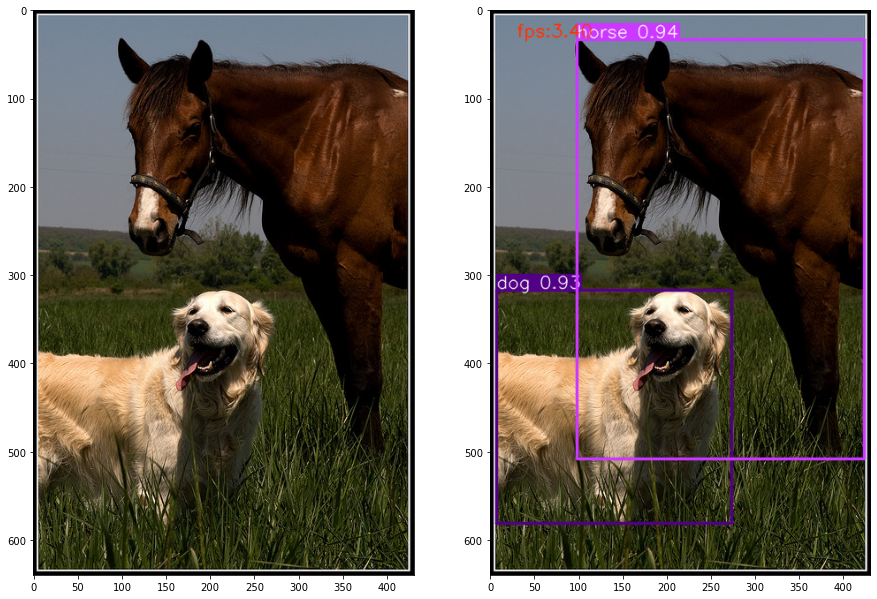

In [15]:

if not os.path.isdir("runs/inference"):
    os.makedirs("runs/inference")


inferer = Inferer(weights = args['weights'], device = args['device'], yaml = args['yaml'], img_size = args['img-size'],
                  half = args['half'], conf_thres= args['conf-thres'], iou_thres= args['iou-thres'],
                  classes = args['classes'],agnostic_nms = args['agnostic-nms'], max_det= args['max-det'])

try:
    img_src = cv2.imread(args['source'])
    assert img_src is not None, f'Invalid image'
except Exception as e:
    print("Invalid Image Path or the image is empty cannot run inference")

start = time.time()
img, img_src = Inferer.precess_image(img_src, inferer.img_size, inferer.model.stride, args['half'])
det = inferer.infer(img, img_src)
end = time.time() - start
fps_txt =  "{:.2f}".format(1/end)
for *xyxy, conf, cls in reversed(det):
  
    class_num = int(cls)  # integer class
    label = None if args['hide-labels'] else (inferer.class_names[class_num] if args['hide-conf'] else f'{inferer.class_names[class_num]} {conf:.2f}')
    Inferer.plot_box_and_label(img_src, max(round(sum(img_src.shape) / 2 * 0.003), 2), xyxy, label, color=Inferer.generate_colors(class_num, True), fps = fps_txt)

image = np.asarray(img_src)

if args['save-img']:

    image_name = args['source'].split('/')[-1]
    cv2.imwrite(os.path.join("runs/inference", image_name), image)

plt.figure(figsize=(15,20))
plt.subplot(121)
plt.imshow(plt.imread(args['source']))
plt.subplot(122)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [25]:
inferer = Inferer(weights = args['weights'], device = args['device'], yaml = args['yaml'], img_size = args['img-size'],half = args['half'], conf_thres= args['conf-thres'], iou_thres= args['iou-thres'],classes = args['classes'],
                  agnostic_nms = args['agnostic-nms'], max_det= args['max-det'])
video_path='Test Project_Trim.avi'
video = cv2.VideoCapture(video_path)


output = cv2.VideoWriter('output2.mp4', cv2.VideoWriter_fourcc(*'DIVX'),10 , (1600,1200))
while True:
    ret, img_src = video.read()
    if not ret:
        break
    start = time.time()
    img, img_src = Inferer.precess_image(img_src, inferer.img_size, inferer.model.stride, args['half'])
    det = inferer.infer(img, img_src)
    end = time.time() - start
    fps_txt =  "{:.2f}".format(1/end)
    for *xyxy, conf, cls in reversed(det):

        class_num = int(cls)  # integer class
        label = None if args['hide-labels'] else (inferer.class_names[class_num] if args['hide-conf'] else f'{inferer.class_names[class_num]} {conf:.2f}')
        Inferer.plot_box_and_label(img_src, max(round(sum(img_src.shape) / 2 * 0.003), 2), xyxy, label, color=Inferer.generate_colors(class_num, True), fps = fps_txt)

    image = np.asarray(img_src)
    output.write(image)
    cv2.imshow('frame',image)
    if cv2.waitKey(1) == ord('q'):
        break
output.release()
video.release()
cv2.destroyAllWindows()

Loading checkpoint from weights/best_ckpt.pt

Fusing model...
